In [1]:
import numpy as np
from matplotlib import pyplot as plt
from classy import Class
from scipy.interpolate import interp1d

# GR

In [2]:
cosmo = Class()
cosmo.set({'output': 'mPk, mTk', 'z_max_pk': 6, 'P_k_max_1/Mpc': 1,
          'k_per_decade_for_pk': 200,
          'k_per_decade_for_bao': 200, 'non linear': 'halofit'})

# cosmo.set({'Omega_Lambda': 0, 'Omega_fld': 0, 'Omega_smg': -1, 
#            'gravity_model': 'mgclass_fs', 'expansion_model': 'lcdm',
#            'parameters_smg': '0, 0', 'expansion_smg': '0.7'})
cosmo.compute()

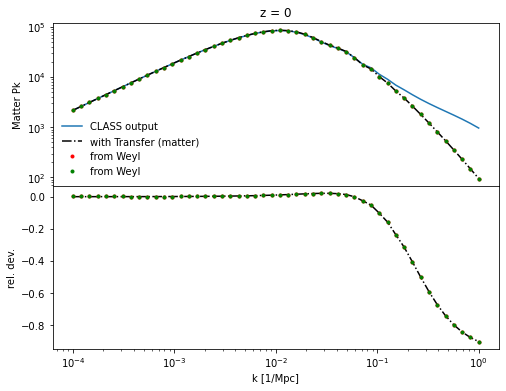

In [3]:
REDSHIFT = 0

k = np.logspace(-4, 0)
h = cosmo.h()
As = cosmo.get_current_derived_parameters(['A_s'])['A_s']
Omega_m = cosmo.Omega_m()
Omega_g = cosmo.Omega_g()
Omega_ur = cosmo.get_background()['(.)rho_ur'][-1] / cosmo.get_background()['(.)rho_crit'][-1]
H0 = cosmo.Hubble(0)

pPk = cosmo.get_primordial()  # Dimensionless primordial spectrum, equal to [k^3/2pi^2] P(k) 
pPk = np.exp(interp1d(np.log(pPk['k [1/Mpc]']), np.log(pPk['P_scalar(k)']))(np.log(k)))
pPk = 2 * np.pi**2 * pPk / k**3  # Make it Mpc^3

mPk = np.array([cosmo.pk(ki, REDSHIFT) for ki in k])

Tks = cosmo.get_transfer(REDSHIFT)
kTk = Tks['k (h/Mpc)'] * h
mTk = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_m']))(np.log(k))
mTk_tot = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_tot']))(np.log(k))
# mTk = -np.exp(interp1d(np.log(Tks['k (h/Mpc)'] * h), np.log(-Tks['d_tot']))(np.log(k)))
mTk_cdm = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_cdm']))(np.log(k)) 
mTk_b = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_b']))(np.log(k)) 
mTk_cb = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_cdm'] + Tks['d_b']))(np.log(k)) 
mTk_all = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_cdm'] + Tks['d_b'] + Tks['d_ur'] + Tks['d_g']))(np.log(k)) 

mPk_from_Tk =  (mTk) ** 2 * pPk
mPk_from_Tk_tot =  (mTk_tot) ** 2 * pPk
mPk_from_Tk_cdm =  (mTk_cdm) ** 2 * pPk
mPk_from_Tk_b =  (mTk_b) ** 2 * pPk
mPk_from_Tk_cb =  (mTk_cb) ** 2 * pPk
mPk_from_Tk_all =  (mTk_all) ** 2 * pPk

# # Using Weyl potential
wTk = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['phi'] + Tks['psi']) / 2, kind='cubic')(np.log(k))
wPk = (wTk) ** 2 * pPk

# # Using Poisson equation
mPk_from_wTk = (- k**2 * 2 / 3 / (H0)**2 / Omega_m / (1 + REDSHIFT)) ** 2 * wPk

# Using Poisson eq having into account rad terms
mTk_from_Tk_phi = (Tks['phi'] * (- kTk**2 * 2 / 3 / (H0)**2 / (1 + REDSHIFT)) - Omega_ur * Tks['d_g']) / Omega_m
mTk_from_Tk_phi = interp1d(np.log(Tks['k (h/Mpc)'] * h), mTk_from_Tk_phi, kind='cubic')(np.log(k))
mPk_from_wTk_with_rad = mTk_from_Tk_phi ** 2 * pPk


#### Plot 

f, ax = plt.subplots(2,1, gridspec_kw={'hspace':0}, sharex=True, figsize=(8,6))
ax[0].loglog(k, mPk, label='CLASS output')
ax[0].loglog(k, mPk_from_Tk, '-.', color='black', label='with Transfer (matter)')
# ax[0].loglog(k, mPk_from_Tk_tot, '-.', color='brown', label='with Transfer (tot)')
# ax[0].loglog(k, mPk_from_Tk_cb, '--k', label='with Transfer (only cdm + baryon)')
# ax[0].loglog(k, mPk_from_Tk_cdm, ':', color='purple', label='with Transfer (only cdm)')
# ax[0].loglog(k, mPk_from_Tk_b, '--', color='pink', label='with Transfer (only baryons)')
# ax[0].loglog(k, mPk_from_Tk_all, '--g', label=r'with Transfer (only cdm + baryon + $\nu$ + rad)')
ax[0].loglog(k, mPk_from_wTk, '.', color='red', label='from Weyl')
ax[0].loglog(k, mPk_from_wTk_with_rad, '.', color='green', label='from Weyl')


ax[1].semilogx(k, mPk_from_Tk / mPk - 1, '-.', color='black')
# ax[1].semilogx(k, mPk_from_Tk_tot / mPk - 1, '-.', color='brown')
# ax[1].semilogx(k, mPk_from_Tk_cb / mPk - 1, '--k')
# ax[1].semilogx(k, mPk_from_Tk_cdm / mPk - 1, ':', color='purple')
# ax[1].semilogx(k, mPk_from_Tk_cdm / mPk - 1, '--', color='pink')
# ax[1].semilogx(k, mPk_from_Tk_all / mPk - 1, '--g')
ax[1].semilogx(k, mPk_from_wTk / mPk - 1, '.r')
ax[1].semilogx(k, mPk_from_wTk_with_rad / mPk - 1, '.g')



ax[0].set_ylabel('Matter Pk')
ax[1].set_xlabel('k [1/Mpc]')
ax[1].set_ylabel('rel. dev.')
ax[0].legend(loc=0, frameon=False)
ax[0].set_title(f'z = {REDSHIFT}')
plt.show()
plt.close()

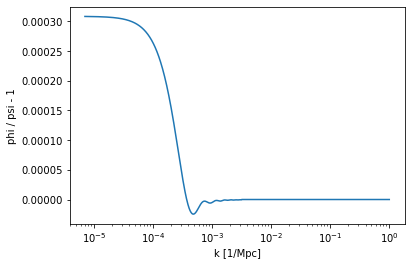

In [39]:
plt.semilogx(Tks['k (h/Mpc)'] * h, Tks['phi'] / Tks['psi'] -1)
plt.ylabel('phi / psi - 1')
plt.xlabel('k [1/Mpc]')
plt.show()
plt.close()

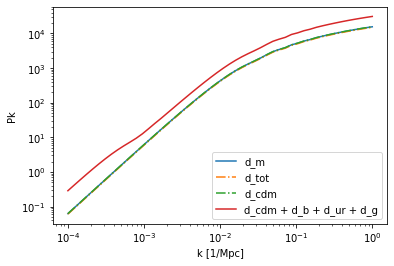

In [13]:
plt.loglog(k, -mTk, label='d_m')
plt.loglog(k, -mTk_tot, '-.', label='d_tot')
plt.loglog(k, -mTk_cdm, '-.', label='d_cdm')
plt.loglog(k, -mTk_all, label='d_cdm + d_b + d_ur + d_g')
plt.xlabel('k [1/Mpc]')
plt.ylabel('Pk')
plt.legend()
plt.show()
plt.close()

In [29]:
list(Tks.keys())

['k (h/Mpc)', 'd_g', 'd_b', 'd_cdm', 'd_ur', 'd_tot', 'phi', 'psi']

In [8]:
Tk = np.loadtxt('../../../codes/MGCAMB/src/output/GR_transfer_out.dat', unpack=True)
mPk = np.loadtxt('../../../codes/MGCAMB/src/output/GR_matterpower.dat', unpack=True)

w


In [ ]:
kTk, wTk = Tk[0], Tk[9]


# $\Sigma \neq 0$ (check $P(k)_{mm} = P(k)_{WW} / \Sigma^2$)

In [9]:
# mu = 0 -> Pk_mm unmodified
# Sigma != 0 -> Pk_ww = Sigma^2 * Pk_mm
cosmo = Class()
cosmo.set({'output': 'mPk, mTk', 'z_max_pk': 6, 'P_k_max_1/Mpc': 1,
          'k_per_decade_for_pk': 200,
          'k_per_decade_for_bao': 200, 'non linear': 'hmcode'})

cosmo.set({'Omega_Lambda': 0, 'Omega_fld': 0, 'Omega_smg': -1, 
           'gravity_model': 'mgclass_fs', 'expansion_model': 'lcdm',
           'use_Sigma': 'yes',
           'parameters_smg': '0, 0.5', 'expansion_smg': '0.7'})
cosmo.compute()

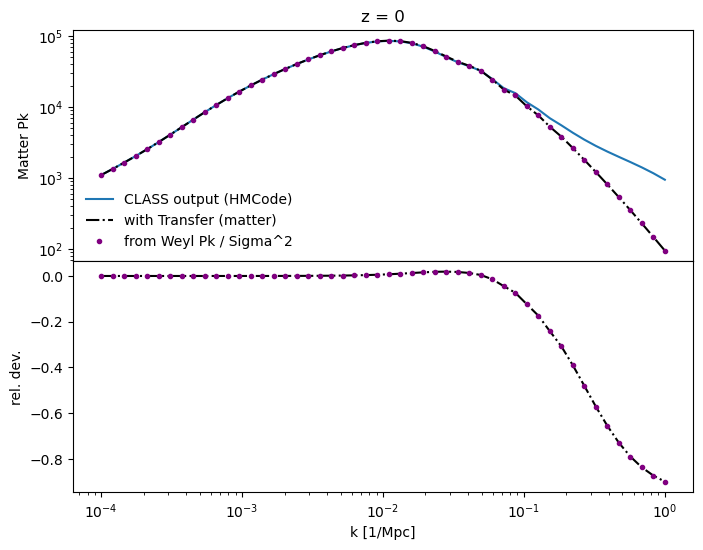

In [11]:
REDSHIFT = 0

k = np.logspace(-4, 0)
h = cosmo.h()
As = cosmo.get_current_derived_parameters(['A_s'])['A_s']
Omega_m = cosmo.Omega_m()
Omega_g = cosmo.Omega_g()
Omega_ur = cosmo.get_background()['(.)rho_ur'][-1] / cosmo.get_background()['(.)rho_crit'][-1]
H0 = cosmo.Hubble(0)
back = cosmo.get_background()
Sigma = interp1d(back['z'], back['mgclass_dSigma'] + 1)(REDSHIFT)

# Pk's from CLASS
pPk = cosmo.get_primordial()  # Dimensionless primordial spectrum, equal to [k^3/2pi^2] P(k) 
pPk = np.exp(interp1d(np.log(pPk['k [1/Mpc]']), np.log(pPk['P_scalar(k)']))(np.log(k)))
pPk = 2 * np.pi**2 * pPk / k**3  # Make it Mpc^3

mPk = np.array([cosmo.pk(ki, REDSHIFT) for ki in k])

# Transfer functions
Tks = cosmo.get_transfer(REDSHIFT)
kTk = Tks['k (h/Mpc)'] * h
mTk = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_m']))(np.log(k))
mTk_tot = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_tot']))(np.log(k))
# mTk = -np.exp(interp1d(np.log(Tks['k (h/Mpc)'] * h), np.log(-Tks['d_tot']))(np.log(k)))
mTk_cdm = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_cdm']))(np.log(k)) 
mTk_b = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_b']))(np.log(k)) 
mTk_cb = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_cdm'] + Tks['d_b']))(np.log(k)) 
mTk_all = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_cdm'] + Tks['d_b'] + Tks['d_ur'] + Tks['d_g']))(np.log(k)) 

mPk_from_Tk =  (mTk) ** 2 * pPk
mPk_from_Tk_tot =  (mTk_tot) ** 2 * pPk
mPk_from_Tk_cdm =  (mTk_cdm) ** 2 * pPk
mPk_from_Tk_b =  (mTk_b) ** 2 * pPk
mPk_from_Tk_cb =  (mTk_cb) ** 2 * pPk
mPk_from_Tk_all =  (mTk_all) ** 2 * pPk

# # Using Weyl potential
wTk = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['phi'] + Tks['psi']) / 2, kind='cubic')(np.log(k))
wPk = (wTk) ** 2 * pPk

# # Using Poisson equation
mPk_from_wPk = (- k**2 * 2 / 3 / (H0)**2 / Omega_m / (1 + REDSHIFT)) ** 2 * wPk

# Using Poisson eq + Sigma factor
mPk_from_wPk_with_Sigma = mPk_from_wPk / Sigma**2

# Using Poisson eq having into account rad terms
mTk_from_Tk_phi = (Tks['phi'] * (- kTk**2 * 2 / 3 / (H0)**2 / (1 + REDSHIFT)) - Omega_ur * Tks['d_g']) / Omega_m
mTk_from_Tk_phi = interp1d(np.log(Tks['k (h/Mpc)'] * h), mTk_from_Tk_phi, kind='cubic')(np.log(k))
mPk_from_wTk_with_rad = mTk_from_Tk_phi ** 2 * pPk


#### Plot 

f, ax = plt.subplots(2,1, gridspec_kw={'hspace':0}, sharex=True, figsize=(8,6))
ax[0].loglog(k, mPk, label='CLASS output (HMCode)')
ax[0].loglog(k, mPk_from_Tk, '-.', color='black', label='with Transfer (matter)')
# ax[0].loglog(k, mPk_from_Tk_tot, '-.', color='brown', label='with Transfer (tot)')
# ax[0].loglog(k, mPk_from_Tk_cb, '--k', label='with Transfer (only cdm + baryon)')
# ax[0].loglog(k, mPk_from_Tk_cdm, ':', color='purple', label='with Transfer (only cdm)')
# ax[0].loglog(k, mPk_from_Tk_b, '--', color='pink', label='with Transfer (only baryons)')
# ax[0].loglog(k, mPk_from_Tk_all, '--g', label=r'with Transfer (only cdm + baryon + $\nu$ + rad)')
# ax[0].loglog(k, mPk_from_wPk, '.', color='red', label='from Weyl Pk')
# ax[0].loglog(k, mPk_from_wTk_with_rad, '.', color='green', label='from Weyl with rad')
ax[0].loglog(k, mPk_from_wPk_with_Sigma, '.', color='purple', label='from Weyl Pk / Sigma^2')


ax[1].semilogx(k, mPk_from_Tk / mPk - 1, '-.', color='black')
# ax[1].semilogx(k, mPk_from_Tk_tot / mPk - 1, '-.', color='brown')
# ax[1].semilogx(k, mPk_from_Tk_cb / mPk - 1, '--k')
# ax[1].semilogx(k, mPk_from_Tk_cdm / mPk - 1, ':', color='purple')
# ax[1].semilogx(k, mPk_from_Tk_cdm / mPk - 1, '--', color='pink')
# ax[1].semilogx(k, mPk_from_Tk_all / mPk - 1, '--g')
# ax[1].semilogx(k, mPk_from_wPk / mPk - 1, '.r')
# ax[1].semilogx(k, mPk_from_wTk_with_rad / mPk - 1, '.g')
ax[1].semilogx(k, mPk_from_wPk_with_Sigma / mPk - 1, '.', color='purple')



ax[0].set_ylabel('Matter Pk')
ax[1].set_xlabel('k [1/Mpc]')
ax[1].set_ylabel('rel. dev.')
ax[0].legend(loc=0, frameon=False)
ax[0].set_title(f'z = {REDSHIFT}')
plt.show()
plt.close()

# Non-linearities

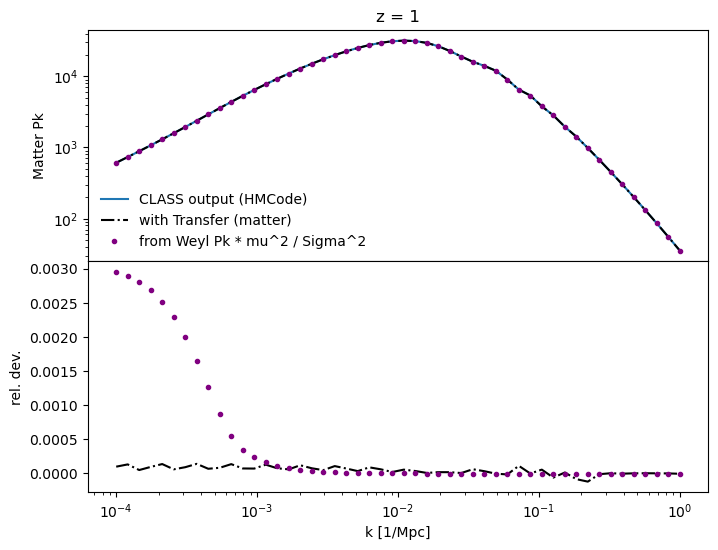

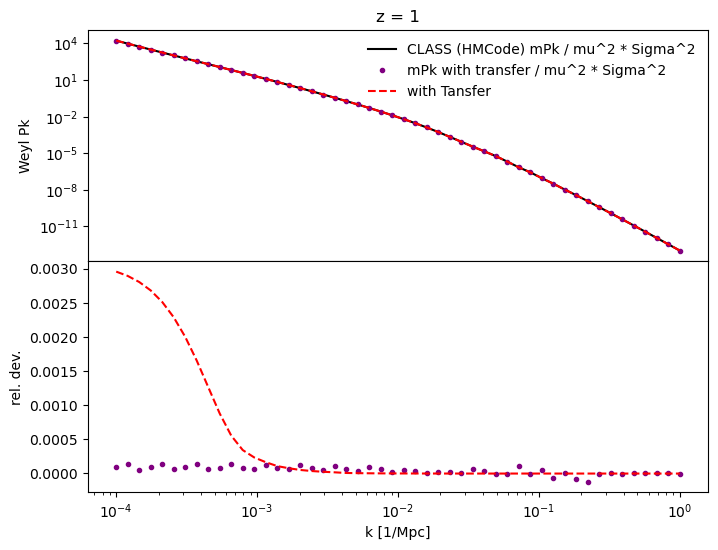

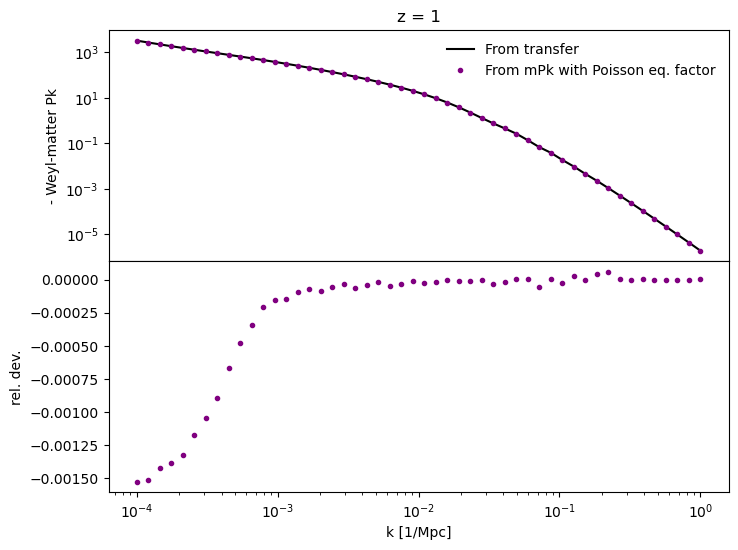

In [20]:
# mu != 0, Sigma != 0 -> Pk_ww = Sigma^2 / mu^2 * Pk_mm
cosmo = Class()
cosmo.set({'output': 'mPk, mTk', 'z_max_pk': 6, 'P_k_max_1/Mpc': 1,
          'k_per_decade_for_pk': 200,
          'k_per_decade_for_bao': 200, 'non linear': 'hmcode'})

cosmo.set({'Omega_Lambda': 0, 'Omega_fld': 0, 'Omega_smg': -1, 
           'gravity_model': 'mgclass_fs', 'expansion_model': 'lcdm',
           'use_Sigma': 'yes',
           'parameters_smg': '0.1, 0.5', 'expansion_smg': '0.7'})
cosmo.compute()

REDSHIFT = 1

k = np.logspace(-4, 0)
h = cosmo.h()
As = cosmo.get_current_derived_parameters(['A_s'])['A_s']
Omega_m = cosmo.Omega_m()
Omega_g = cosmo.Omega_g()
Omega_ur = cosmo.get_background()['(.)rho_ur'][-1] / cosmo.get_background()['(.)rho_crit'][-1]
H0 = cosmo.Hubble(0)
back = cosmo.get_background()
mu = interp1d(back['z'], back['mgclass_dmu'] + 1)(REDSHIFT)
Sigma = interp1d(back['z'], back['mgclass_dSigma'] + 1)(REDSHIFT)

# Primordial Pk
pPk = cosmo.get_primordial()  # Dimensionless primordial spectrum, equal to [k^3/2pi^2] P(k) 
pPk = np.exp(interp1d(np.log(pPk['k [1/Mpc]']), np.log(pPk['P_scalar(k)']))(np.log(k)))
pPk = 2 * np.pi**2 * pPk / k**3  # Make it Mpc^3

# Transfer functions
Tks = cosmo.get_transfer(REDSHIFT)
kTk = Tks['k (h/Mpc)'] * h
mTk = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_m']))(np.log(k))
wTk = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['phi'] + Tks['psi']) / 2, kind='cubic')(np.log(k))

# Pk's
# Matter
mPk = np.array([cosmo.pk(ki, REDSHIFT) for ki in k])
mPk_from_Tk =  (mTk) ** 2 * pPk

# Weyl
wPk_from_Tk = (wTk) ** 2 * pPk

# Matter Pk from Weyl Pk using Poisson equation
Poisson_eq_factor = -k**2 * 2 / 3 / (H0)**2 / Omega_m / (1 + REDSHIFT) / Sigma
mPk_from_wPk =  Poisson_eq_factor**2 * wPk_from_Tk

# Weyl Pk from matter Pk using Poisson equation
wPk_from_mPk_with_mu_Sigma = mPk / Poisson_eq_factor**2
wPk_from_mPk_from_Tk_with_mu_Sigma = mPk_from_Tk / Poisson_eq_factor**2

# Weyl-matter Pk
wmPk = wTk * mTk * pPk
wmPk_from_mPk = mPk / Poisson_eq_factor

#### Plot mPk

f, ax = plt.subplots(2,1, gridspec_kw={'hspace':0}, sharex=True, figsize=(8,6))
ax[0].loglog(k, mPk, label='CLASS output (HMCode)')
ax[0].loglog(k, mPk_from_Tk, '-.', color='black', label='with Transfer (matter)')
ax[0].loglog(k, mPk_from_wPk, '.', color='purple', label='from Weyl Pk * mu^2 / Sigma^2')

ax[1].semilogx(k, mPk_from_Tk / mPk - 1, '-.', color='black')
ax[1].semilogx(k, mPk_from_wPk / mPk - 1, '.', color='purple')


ax[0].set_ylabel('Matter Pk')
ax[1].set_xlabel('k [1/Mpc]')
ax[1].set_ylabel('rel. dev.')
ax[0].legend(loc=0, frameon=False)
ax[0].set_title(f'z = {REDSHIFT}')
plt.show()
plt.close()


#### Plot wPk

f, ax = plt.subplots(2,1, gridspec_kw={'hspace':0}, sharex=True, figsize=(8,6))
ax[0].loglog(k, wPk_from_mPk_with_mu_Sigma, color='black', label='CLASS (HMCode) mPk / mu^2 * Sigma^2')
ax[0].loglog(k, wPk_from_mPk_from_Tk_with_mu_Sigma, '.', color='purple', label='mPk with transfer / mu^2 * Sigma^2')
ax[0].loglog(k, wPk_from_Tk, '--', color='red', label='with Tansfer')

ax[1].semilogx(k, wPk_from_mPk_from_Tk_with_mu_Sigma / wPk_from_mPk_with_mu_Sigma - 1, '.', color='purple')
ax[1].semilogx(k, wPk_from_Tk / wPk_from_mPk_with_mu_Sigma - 1, '--', color='red')


ax[0].set_ylabel('Weyl Pk')
ax[1].set_xlabel('k [1/Mpc]')
ax[1].set_ylabel('rel. dev.')
ax[0].legend(loc=0, frameon=False)
ax[0].set_title(f'z = {REDSHIFT}')
plt.show()
plt.close()

#### Plot wmPk

f, ax = plt.subplots(2,1, gridspec_kw={'hspace':0}, sharex=True, figsize=(8,6))
ax[0].loglog(k, -wmPk, color='black', label='From transfer')
ax[0].loglog(k, -wmPk_from_mPk, '.', color='purple', label='From mPk with Poisson eq. factor')

ax[1].semilogx(k, wmPk_from_mPk / wmPk - 1, '.', color='purple')

ax[0].set_ylabel('- Weyl-matter Pk')
ax[1].set_xlabel('k [1/Mpc]')
ax[1].set_ylabel('rel. dev.')
ax[0].legend(loc=0, frameon=False)
ax[0].set_title(f'z = {REDSHIFT}')
plt.show()
plt.close()

# Check Pk for a model of the chains that failed to integrate

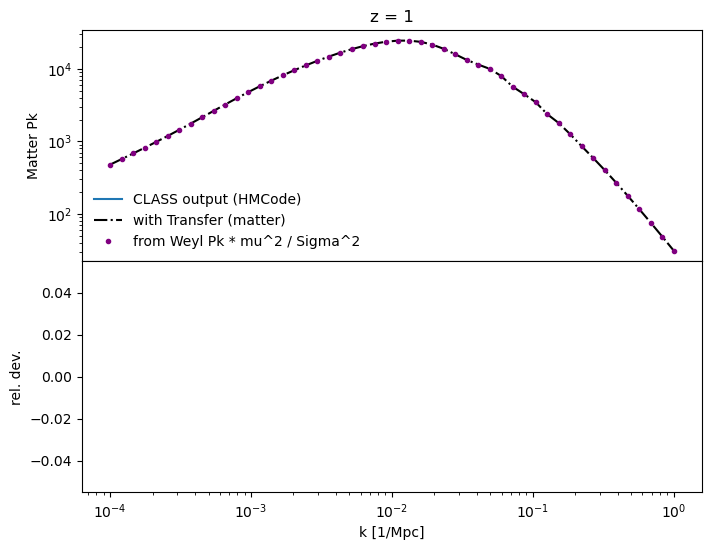

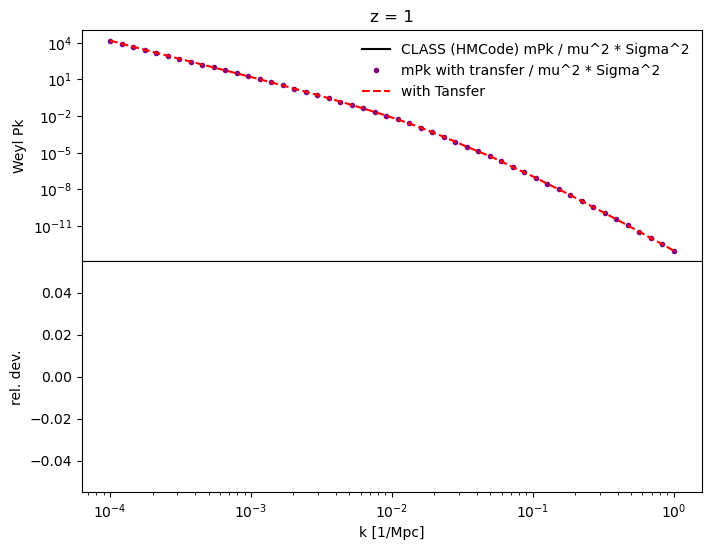

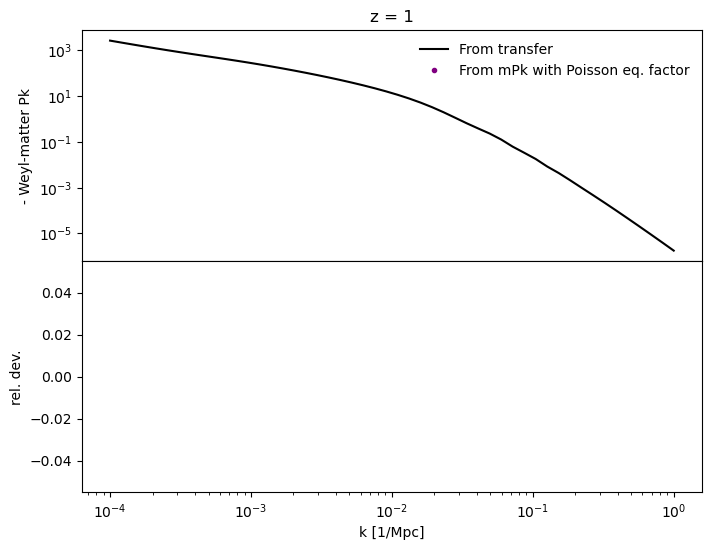

In [16]:
# mu != 0, Sigma != 0 -> Pk_ww = Sigma^2 / mu^2 * Pk_mm
cosmo = Class()
cosmo.set({'output': 'mPk, mTk', 'z_max_pk': 6, 'P_k_max_1/Mpc': 1,
          'k_per_decade_for_pk': 200,
          'k_per_decade_for_bao': 200, 'non linear': 'hmcode'})

cosmo.set({'Omega_Lambda': 0, 'Omega_fld': 0, 'Omega_smg': -1, 
           'gravity_model': 'mgclass_fs', 'expansion_model': 'lcdm',
           'use_Sigma': 'yes',
           'parameters_smg': '0.1, 0.5', 'expansion_smg': '0.7'})

# Form chain that failed to integrate the Cell
# cosmo.set({'gravity_model': 'mgclass_fs', 'use_Sigma': 'yes', 'expansion_model': 'lcdm',
#            'Omega_Lambda': 0, 'Omega_fld': 0, 'Omega_smg': -1,
#            'non linear': 'hmcode', 'Omega_b': 0.0631036282607493,
#            'Omega_cdm': 0.2686220184377077, 'A_s': 2.7447793899805345e-09,
#            'n_s': 0.9641991358093566, 'h': 0.7032495762598434, 'tau_reio': 0.08,
#            'expansion_smg': 0.7, 'parameters_smg': '-1.55027, -0.23348'})

cosmo.set({'gravity_model': 'mgclass_fs', 'use_Sigma': 'yes', 'expansion_model': 'lcdm',
           'Omega_Lambda': 0, 'Omega_fld': 0, 'Omega_smg': -1, 
           'non linear': 'hmcode', 'Omega_b': 0.05459237629292364, 
           'Omega_cdm': 0.2796145342160704, 'A_s': 2.1455970634707376e-09, 
           'n_s': 0.9097423532907881, 'h': 0.7117481170956932, 'tau_reio': 0.08, 
           'expansion_smg': 0.7, 'parameters_smg': '-2.63428, -0.0452764'})

cosmo.compute()

REDSHIFT = 1

k = np.logspace(-4, 0)
h = cosmo.h()
As = cosmo.get_current_derived_parameters(['A_s'])['A_s']
Omega_m = cosmo.Omega_m()
Omega_g = cosmo.Omega_g()
Omega_ur = cosmo.get_background()['(.)rho_ur'][-1] / cosmo.get_background()['(.)rho_crit'][-1]
H0 = cosmo.Hubble(0)
back = cosmo.get_background()
mu = interp1d(back['z'], back['mgclass_dmu'] + 1)(REDSHIFT)
Sigma = interp1d(back['z'], back['mgclass_dSigma'] + 1)(REDSHIFT)

# Primordial Pk
pPk = cosmo.get_primordial()  # Dimensionless primordial spectrum, equal to [k^3/2pi^2] P(k) 
pPk = np.exp(interp1d(np.log(pPk['k [1/Mpc]']), np.log(pPk['P_scalar(k)']))(np.log(k)))
pPk = 2 * np.pi**2 * pPk / k**3  # Make it Mpc^3

# Transfer functions
Tks = cosmo.get_transfer(REDSHIFT)
kTk = Tks['k (h/Mpc)'] * h
mTk = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['d_m']))(np.log(k))
wTk = interp1d(np.log(Tks['k (h/Mpc)'] * h), (Tks['phi'] + Tks['psi']) / 2, kind='cubic')(np.log(k))

# Pk's
# Matter
mPk = np.array([cosmo.pk(ki, REDSHIFT) for ki in k])
mPk_from_Tk =  (mTk) ** 2 * pPk

# Weyl
wPk_from_Tk = (wTk) ** 2 * pPk

# Matter Pk from Weyl Pk using Poisson equation
Poisson_eq_factor = -k**2 * 2 / 3 / (H0)**2 / Omega_m / (1 + REDSHIFT) / Sigma
mPk_from_wPk =  Poisson_eq_factor**2 * wPk_from_Tk

# Weyl Pk from matter Pk using Poisson equation
wPk_from_mPk_with_mu_Sigma = mPk / Poisson_eq_factor**2
wPk_from_mPk_from_Tk_with_mu_Sigma = mPk_from_Tk / Poisson_eq_factor**2

# Weyl-matter Pk
wmPk = wTk * mTk * pPk
wmPk_from_mPk = mPk / Poisson_eq_factor

#### Plot mPk

f, ax = plt.subplots(2,1, gridspec_kw={'hspace':0}, sharex=True, figsize=(8,6))
ax[0].loglog(k, mPk, label='CLASS output (HMCode)')
ax[0].loglog(k, mPk_from_Tk, '-.', color='black', label='with Transfer (matter)')
ax[0].loglog(k, mPk_from_wPk, '.', color='purple', label='from Weyl Pk * mu^2 / Sigma^2')

ax[1].semilogx(k, mPk_from_Tk / mPk - 1, '-.', color='black')
ax[1].semilogx(k, mPk_from_wPk / mPk - 1, '.', color='purple')


ax[0].set_ylabel('Matter Pk')
ax[1].set_xlabel('k [1/Mpc]')
ax[1].set_ylabel('rel. dev.')
ax[0].legend(loc=0, frameon=False)
ax[0].set_title(f'z = {REDSHIFT}')
plt.show()
plt.close()


#### Plot wPk

f, ax = plt.subplots(2,1, gridspec_kw={'hspace':0}, sharex=True, figsize=(8,6))
ax[0].loglog(k, wPk_from_mPk_with_mu_Sigma, color='black', label='CLASS (HMCode) mPk / mu^2 * Sigma^2')
ax[0].loglog(k, wPk_from_mPk_from_Tk_with_mu_Sigma, '.', color='purple', label='mPk with transfer / mu^2 * Sigma^2')
ax[0].loglog(k, wPk_from_Tk, '--', color='red', label='with Tansfer')

ax[1].semilogx(k, wPk_from_mPk_from_Tk_with_mu_Sigma / wPk_from_mPk_with_mu_Sigma - 1, '.', color='purple')
ax[1].semilogx(k, wPk_from_Tk / wPk_from_mPk_with_mu_Sigma - 1, '--', color='red')


ax[0].set_ylabel('Weyl Pk')
ax[1].set_xlabel('k [1/Mpc]')
ax[1].set_ylabel('rel. dev.')
ax[0].legend(loc=0, frameon=False)
ax[0].set_title(f'z = {REDSHIFT}')
plt.show()
plt.close()

#### Plot wmPk

f, ax = plt.subplots(2,1, gridspec_kw={'hspace':0}, sharex=True, figsize=(8,6))
ax[0].loglog(k, -wmPk, color='black', label='From transfer')
ax[0].loglog(k, -wmPk_from_mPk, '.', color='purple', label='From mPk with Poisson eq. factor')

ax[1].semilogx(k, wmPk_from_mPk / wmPk - 1, '.', color='purple')

ax[0].set_ylabel('- Weyl-matter Pk')
ax[1].set_xlabel('k [1/Mpc]')
ax[1].set_ylabel('rel. dev.')
ax[0].legend(loc=0, frameon=False)
ax[0].set_title(f'z = {REDSHIFT}')
plt.show()
plt.close()

In [17]:
Poisson_eq_factor

array([-1.78561615e-01, -2.60047936e-01, -3.78720415e-01, -5.51548900e-01,
       -8.03247401e-01, -1.16980813e+00, -1.70364829e+00, -2.48110559e+00,
       -3.61335435e+00, -5.26230310e+00, -7.66374711e+00, -1.11610864e+01,
       -1.62544312e+01, -2.36721162e+01, -3.44748504e+01, -5.02073959e+01,
       -7.31194645e+01, -1.06487421e+02, -1.55082793e+02, -2.25854590e+02,
       -3.28922988e+02, -4.79026493e+02, -6.97629503e+02, -1.01599167e+03,
       -1.47963791e+03, -2.15486842e+03, -3.13823935e+03, -4.57037010e+03,
       -6.65605153e+03, -9.69353052e+03, -1.41171584e+04, -2.05595022e+04,
       -2.99417997e+04, -4.36056944e+04, -6.35050866e+04, -9.24855362e+04,
       -1.34691170e+05, -1.96157280e+05, -2.85673356e+05, -4.16039957e+05,
       -6.05899158e+05, -8.82400317e+05, -1.28508236e+06, -1.87152774e+06,
       -2.72559657e+06, -3.96941841e+06, -5.78085646e+06, -8.41894151e+06,
       -1.22609126e+07, -1.78561615e+07])

In [18]:
mPk

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Model 1, pk(z=0) =  nan
Model 2, pk(z=0) =  nan


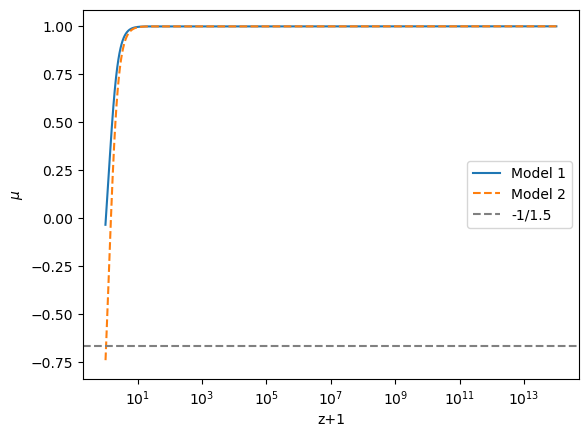

In [39]:
cosmo = Class()
cosmo.set({'output': 'mPk, mTk', 'z_max_pk': 6, 'P_k_max_1/Mpc': 1,
          'k_per_decade_for_pk': 200,
          'k_per_decade_for_bao': 200, 'non linear': 'hmcode'})

# Model 1
cosmo.set({'gravity_model': 'mgclass_fs', 'use_Sigma': 'yes', 'expansion_model': 'lcdm',
           'Omega_Lambda': 0, 'Omega_fld': 0, 'Omega_smg': -1,
           'non linear': 'hmcode', 'Omega_b': 0.0631036282607493,
           'Omega_cdm': 0.2686220184377077, 'A_s': 2.7447793899805345e-09,
           'n_s': 0.9641991358093566, 'h': 0.7032495762598434, 'tau_reio': 0.08,
           'expansion_smg': 0.7, 'parameters_smg': '-1.55027, -0.23348'})
cosmo.compute()
print('Model 1, pk(z=0) = ', cosmo.pk(k[0], 0))
back = cosmo.get_background()
plt.semilogx(back['z']+1, back['mgclass_dmu'] + 1, label='Model 1')

# Model 2
cosmo.set({'gravity_model': 'mgclass_fs', 'use_Sigma': 'yes', 'expansion_model': 'lcdm',
           'Omega_Lambda': 0, 'Omega_fld': 0, 'Omega_smg': -1, 
           'non linear': 'hmcode', 'Omega_b': 0.05459237629292364, 
           'Omega_cdm': 0.2796145342160704, 'A_s': 2.1455970634707376e-09, 
           'n_s': 0.9097423532907881, 'h': 0.7117481170956932, 'tau_reio': 0.08, 
           'expansion_smg': 0.7, 'parameters_smg': '-2.63428, -0.0452764'})
cosmo.compute()
print('Model 2, pk(z=0) = ', cosmo.pk(k[0], 0))
back = cosmo.get_background()
plt.semilogx(back['z']+1, back['mgclass_dmu'] + 1, ls='--', label='Model 2')

plt.axhline(-1/1.5, ls='--', color='gray', label='-1/1.5')
plt.xlabel('z+1')
plt.ylabel(r'$\mu$')
plt.legend()
plt.show()
plt.close()